In [4]:
from matplotlib import pyplot as plt 
import torch
import torchvision
import numpy as np 
import pickle as pkl
import os
from scipy.stats import spearmanr
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import statsmodels.api as sm

import sys 
sys.path.append('../src/')
from utils import load_config, get_corruption_scores, load_data

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load results

In [23]:
out_dir = '../results/exp9'

res = pd.read_csv(f'{out_dir}/results.csv', sep='\t')
res.tail()

,uid,config,config-checksum,method,perf_filter_low,perf_filter_high,runtime_s
4,d039bca1-db3b-419a-984c-c90d659adeb6,../configs/exp9.py,7fda8bf7b6ff289986265c07c4f7301d,apc,"[0.5446721050475989, 0.5460765748397177, 0.545...","[0.5460794409648685, 0.5004156623242253, 0.495...",580.629185
5,c4bde617-c85e-4795-a229-9c6b0fd86685,../configs/exp9.py,7fda8bf7b6ff289986265c07c4f7301d,dvrl,"[0.5376693360256, 0.5386716300679386, 0.537005...","[0.5376823716830336, 0.37620287920574025, 0.16...",2939.960701
6,32903a02-1aa2-4a48-91bf-8fec2017d866,../configs/exp9.py,fb1fc9baf981d5b864540517326ba528,dvgs,"[0.37050692876381464, 0.3710821725852407, 0.37...","[0.3718095196669918, 0.34428378967351964, 0.33...",5965.998089
7,460af3fe-8039-4114-a41f-cea221947870,../configs/exp9.py,8b0a672f55533933f3a0a774d9b1d72a,dvgs,"[0.38382925774337795, 0.38558532274636115, 0.3...","[0.383495396029547, 0.35655916617412753, 0.349...",6876.683777
8,f8e28034-211c-4951-96c6-fe11eb510319,../configs/exp9.py,ab19c4458bd90f363204dda6fe0b106d,dvgs,"[0.40476187961383076, 0.4052954024927965, 0.40...","[0.40503318809254785, 0.36936324458992126, 0.3...",26599.154014


In [24]:
res = res.iloc[[-1, -2]]
res

,uid,config,config-checksum,method,perf_filter_low,perf_filter_high,runtime_s
8,f8e28034-211c-4951-96c6-fe11eb510319,../configs/exp9.py,ab19c4458bd90f363204dda6fe0b106d,dvgs,"[0.40476187961383076, 0.4052954024927965, 0.40...","[0.40503318809254785, 0.36936324458992126, 0.3...",26599.154014
7,460af3fe-8039-4114-a41f-cea221947870,../configs/exp9.py,8b0a672f55533933f3a0a774d9b1d72a,dvgs,"[0.38382925774337795, 0.38558532274636115, 0.3...","[0.383495396029547, 0.35655916617412753, 0.349...",6876.683777


In [25]:
vals_dict = {uid:
                {
                 'vals':np.load(f'{out_dir}/data_values/{uid}/data_values.npy', allow_pickle=True), 
                 'exog':np.load(f'{out_dir}/data_values/{uid}/exog_noise.npy', allow_pickle=True),
                 'endog':np.load(f'{out_dir}/data_values/{uid}/endog_noise.npy', allow_pickle=True)
                } 
            for uid in res.uid.values}

In [26]:
# check that all config-checksums are identical; if not, it may have changed between runs 
if res['config-checksum'].unique().shape[0] > 1: 
    print('WARNING! config checksums are not identical, config file may have changed between runs.')

# check that the same config file was used 
if res['config'].unique().shape[0] > 1: 
    print('WARNING! Different config. files were used between runs.')

WARNING! config checksums are not identical, config file may have changed between runs.


In [27]:
config = load_config(res.config.values[0])

# corrupted label identification 

In [28]:
spearman_corr = {m:[] for m in res.method.unique()}

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    pp_corr = []
    for i,row in _temp.iterrows(): 

        exog_noise = vals_dict[row.uid]['exog']
        vals = vals_dict[row.uid]['vals']

        spearman_corr[method].append(spearmanr(exog_noise, vals)[0])

        lowess = sm.nonparametric.lowess
        lowess_fit = lowess(vals.ravel(), np.array(exog_noise).ravel(), return_sorted=False, frac=0.4)

        plt.figure(figsize=(5, 5))
        plt.plot(exog_noise, vals, "k.", label='data')
        plt.plot(exog_noise, lowess_fit, "r.", label='lowess')
        plt.xlabel('sample exog. noise rate')
        plt.ylabel('data value')
        plt.title(f'method: {method}')
        plt.grid(visible=True)
        plt.legend()
        plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 710216

In [29]:
table_latex = [[config.dataset]]
for method in ['dvgs', 'dshap', 'dvrl', 'loo', 'random']: 
    if method in spearman_corr: 
        table_latex.append( [f'{np.mean(spearman_corr[method]):.3f} $\pm$ {2*np.std(spearman_corr[method]):.3f}'] )
    else: 
        table_latex.append(['NA'])

table_latex = pd.DataFrame(table_latex).T 
table_latex.columns= ['Dataset', 'dvgs', 'dshap', 'dvrl', 'loo', 'random']

print()
#table_latex.style.to_latex()

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [30]:
table_latex

,Dataset,dvgs,dshap,dvrl,loo,random
0,lincs,nan $\pm$ nan,NA,NA,NA,NA


# Filtered Data Performance

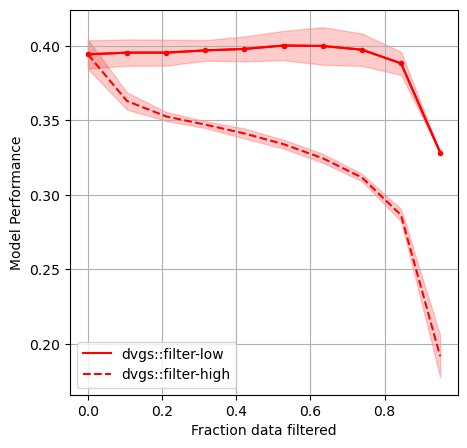

In [31]:
plt.figure(figsize=(5, 5))

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    _low = [] 
    _high = [] 
    for i,row in _temp.iterrows(): 
        _low.append(row.perf_filter_low.strip('[]').split(','))
        _high.append(row.perf_filter_high.strip('[]').split(','))

    _low = np.stack(_low, axis=0).astype(float)
    _high = np.stack(_high, axis=0).astype(float)

    plt.plot(config.filter_kwargs['qs'], _low.mean(axis=0), color=c, label=f'{method}::filter-low', linestyle='-')
    plt.plot(config.filter_kwargs['qs'], _low.mean(axis=0), color=c, marker='.')
    plt.fill_between(config.filter_kwargs['qs'], np.quantile(a=_low, q=0.05, axis=0), np.quantile(a=_low, q=0.95, axis=0), color=c, alpha=.2)

    plt.plot(config.filter_kwargs['qs'], _high.mean(axis=0), color=c, linestyle='--', label=f'{method}::filter-high')
    #plt.plot(config.filter_kwargs['qs'], _high.mean(axis=0), color=c, marker='.', linestyle=None)
    plt.fill_between(config.filter_kwargs['qs'], np.quantile(a=_high, q=0.05, axis=0), np.quantile(a=_high, q=0.95, axis=0), color=c, alpha=.2)

plt.legend()
plt.xlabel('Fraction data filtered')
plt.ylabel('Model Performance')
plt.grid(visible=None)
plt.show()